In [1]:
%matplotlib inline

import oscars.sr
from oscars.plots_mpl import *
from oscars.util import *
from oscars.fit import *

import numpy as np
from glob import glob

OSCARS v2.1.0.dev2 - Open Source Code for Advanced Radiation Simulation
Brookhaven National Laboratory, Upton NY, USA
http://oscars.bnl.gov
oscars@bnl.gov


In [2]:
osr = oscars.sr.sr(gpu=1, nthreads=8)

GPU is not available: Setting gpu global setting to 0.


In [3]:
osr.set_particle_beam(beam='NSLSII', x0=[0, 0, -1])
osr.set_ctstartstop(0, 2)

In [4]:
# For reading and interpolating a list of files
file_list = read_file_list('/home/alex/Workspace/OSCARS/notebook/NSLSII-MM-Data/LIX/file_list.txt')

In [5]:
gaps = np.arange(11.5, 20, 0.5).tolist() + np.arange(20., 40., 1.).tolist() + np.arange(40., 105., 5.).tolist()

In [6]:
print('ngaps:', len(gaps))

ngaps: 50


In [7]:
for gap in gaps:
    print('gap', gap)
    osr.clear_bfields()
    osr.add_bfield_interpolated(mapping=file_list,
                                iformat='OSCARS1D Z Bx By Bz',
                                parameter=gap,
                                scale=[0.001],
                                name='U42'
                               )
    osr.calculate_spectrum(obs=[0, 0, 30],
                           energy_range_eV=[10, 10000],
                           ofile='spectra_spectrum_se_u42_gap_' + str(gap).zfill(5) + '.dat'
                           )

gap 11.5
gap 12.0
gap 12.5
gap 13.0
gap 13.5
gap 14.0
gap 14.5
gap 15.0
gap 15.5
gap 16.0
gap 16.5
gap 17.0
gap 17.5
gap 18.0
gap 18.5
gap 19.0
gap 19.5
gap 20.0
gap 21.0
gap 22.0
gap 23.0
gap 24.0
gap 25.0
gap 26.0
gap 27.0
gap 28.0
gap 29.0
gap 30.0
gap 31.0
gap 32.0
gap 33.0
gap 34.0
gap 35.0
gap 36.0
gap 37.0
gap 38.0
gap 39.0
gap 40.0
gap 45.0
gap 50.0
gap 55.0
gap 60.0
gap 65.0
gap 70.0
gap 75.0
gap 80.0
gap 85.0
gap 90.0
gap 95.0
gap 100.0


In [8]:
files = glob('spectra/spectrum_se_u42_gap_*.dat')

In [18]:
def find_spacing (spectrum, maxh=8):
    print('hello')
    try:
        fit_1 = fit_spectrum_gaussian(spectrum, n=1, quiet=True)[0][1]
    except ValueError:
        print('failed 1 fit')
        Y = [s[1] for s in spectrum]
        X = [s[0] for s in spectrum]
        ind = Y.index(max(Y))
        return X[ind]

    if maxh == 1:
        print('return fit_1')
        return fit_1
    
    try:
        f2 = fit_spectrum_gaussian(spectrum, n=2, quiet=True)[0][1]
    except ValueError:
        print('return fit_1 failed 2')
        return fit_1

    if maxh == 2:
        return f2


    try:
        last_spacing=0
        for i in range(3, maxh):
            points = [fit[1] for fit in fit_spectrum_gaussian(spectrum, n=i, quiet=True)]

            diffs=[]
            for j in range(1, len(points)):
                diffs.append(points[j] - points[j-1])
                spacing = np.mean(diffs)
                if abs(last_spacing - spacing)/spacing < 0.01:
                    print('found spacing!')
                    return spacing/2
                last_spacing = spacing
    except ValueError:
        print('failed all fit')

    return fit_1


def find_first_harmonic (spectrum, xguess, xwidth=50):
    print('xguess', xguess)
    return fit_spectrum_gaussian(spectrum, xranges=[[xguess-xwidth, xguess+xwidth]], quiet=True)

def find_odd_harmonics (spectrum, first, xwidth=50, figsize=None):
    
        
    xranges=[]
    for x in np.arange(first[0][1], spectrum[-1][0], 2*first[0][1], dtype=float):
        xranges.append([x - xwidth, x + xwidth])
        #fits.append( fit_spectrum_gaussian(spectrum, xranges=[[x - xwidth, x + xwidth]]) )
    print('nxranges', len(xranges))
    fits = fit_spectrum_gaussian(spectrum, xranges=xranges, figsize=figsize)
    return fits

In [19]:
X

[]

In [14]:
fits=[]
gaps=[]
for file in files:
    gap = float(file.split('_')[-1][0:5])
    print('gap', gap)
    spectrum = osr.average_spectra(ifiles=[file])
    
    if gap > 78:
        continue
        
    hmax = 8
    if gap > 45.:
        hmax = 1
        
    spacing = find_spacing(spectrum, hmax)
    first = find_first_harmonic(spectrum, spacing)

    fit = find_odd_harmonics(spectrum, first, figsize=[12, 3])
    fits.append(fit)
    gaps.append(gap)

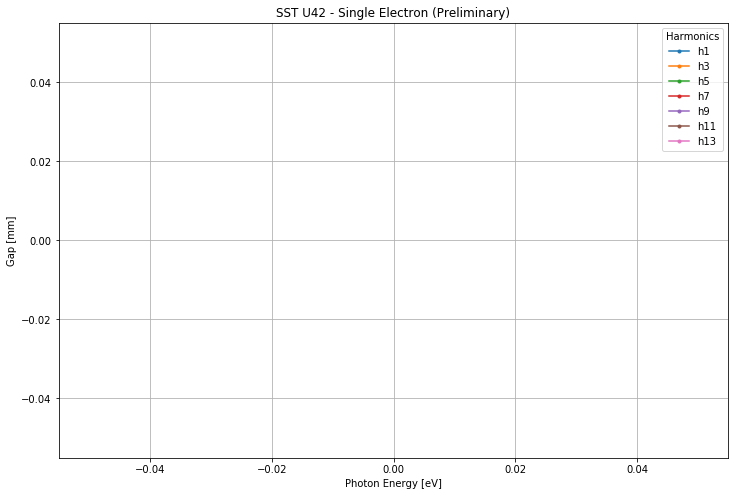

In [15]:
plt.figure(1, figsize=[12, 8])

#for i in range(len(fits[0])):
for i in range(7):

    X=[]
    Y=[]
    for j in range(len(fits)):
        fit = fits[j]
        if i < len(fit):
            X.append(gaps[j])
            Y.append(fit[i][1])
    plt.plot(Y, X, '.-', label='h'+str(1+2*i))

plt.title('SST U42 - Single Electron (Preliminary)')
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Gap [mm]')

plt.legend(title='Harmonics')

plt.grid()

plt.show()

In [21]:
gaps

[]

In [23]:
fits

[]

/home/alex/py-venv/lib/python3.5/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


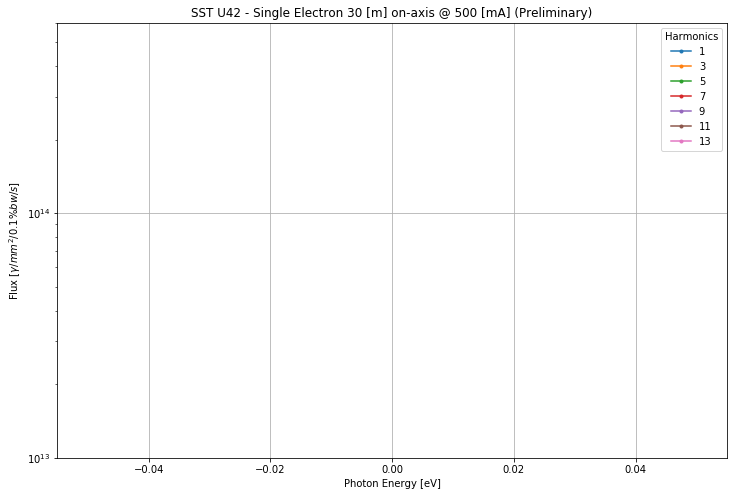

In [16]:
plt.figure(1, figsize=[12, 8])

#for i in range(len(fits[0])):
for i in range(7):

    X=[]
    Y=[]
    for j in range(len(fits)):
        fit = fits[j]
        if i < len(fit):
            X.append(fit[i][0])
            Y.append(fit[i][1])
    plt.plot(Y, X, '.-', label=str(1+2*i))
plt.semilogy(1)
#plt.semilogx(1)


plt.ylim([1e13, 6e14])

plt.title('SST U42 - Single Electron 30 [m] on-axis @ 500 [mA] (Preliminary)')
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Flux [$\gamma / mm^2 / 0.1\%bw / s$]')

plt.legend(title='Harmonics')

plt.grid()

plt.show()



In [17]:
X

[]